In [1]:
# # IMPORTS
# astronomy
from astropy.io import fits
# plotting 
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.pyplot as plt
import matplotlib as mpl
# data 
import numpy as np
# file IO
import csv
# my python files 
import match
import v2_AGN_DataAndPlotting as adp

# Read Data

In [2]:
# open COSMOS 2020 catalog file and get data 
with fits.open(adp.path_cat+'\\COSMOS2020_CLASSIC_R1_v2.0_master.fits') as hdul20:
    data20 = hdul20[1].data
    cols20 = hdul20[1].columns

In [3]:
# get IRAC data (unit = 'uJy')
ch1_data20  = np.array(data20['SPLASH_CH1_FLUX']) # 3.5686 um
print('.', end='')
ch2_data20  = np.array(data20['SPLASH_CH2_FLUX']) # 4.5067 um
print('.', end='')
ch3_data20  = np.array(data20['SPLASH_CH3_FLUX']) # 5.7788 um
print('.', end='')
ch4_data20  = np.array(data20['SPLASH_CH4_FLUX']) # 7.9958 um 
print('.', end='')
# get ID
id_data20 = np.array(data20['ID_COSMOS2015'])
print('.', end='')

.....

In [4]:
# open COSMOS 2016 catalog file and get data 
with fits.open(adp.path_cat+'\\chandra_COSMOS_legacy_opt_NIR_counterparts_20160113_4d.fits') as hdul16:
    data16 = hdul16[1].data
    cols16 = hdul16[1].columns

In [5]:
# get data arrays from columns
id_data16 = np.array(data16['id_k_uv'])
print('.', end='')
L0510_data16 = np.array(data16['Lx_0510']) # x-ray luminosity in the 0.5-10 KeV band
print('.', end='')
k0510_data16 = np.array(data16['abs_corr_0510'])  # absorbtion correction coefficient in the 0.5-10 KeV band
print('.', end='')

...

In [6]:
def ReadRedshifts(file, printInfo=True) : 
    # read redshifts from file 
    zAll = np.array(adp.ReadFile(file))
    zID, zZ = zAll.T
    # get correct data type
    zID = np.array(zID, dtype=int)
    zZ  = np.array(zZ,  dtype=float)
    # apply mask to remove bad redshifts
    mask_z = (zZ >= 0) & (zZ < 99)
    zID = zID[mask_z]
    zZ  = zZ[mask_z]
    # print info
    if(printInfo):
        print('Number of redshifts:', len(zID))
    # build dict
    zdict = {
        'ID' : zID,
        'z' : zZ
    }
    # return dictionary of valid redshifts and IDs
    return(zdict)

# get redshifts less than or equal to zMax
def GetRedshifts_lessEq(zMax, zDict, printInfo=True) : 
    # get mask of 0<z<zMax
    mask_lt = (zDict['z'] > 0.0) & (zDict['z'] <= 1.0)
    # make dict of z
    zDict_lt = {
        'ID' : zDict['ID'][mask_lt],
        'z'  : zDict['z'][mask_lt]
    }
    # print info
    if(printInfo):
        print('Number of redshifts <='+str(zMax)+':', len(zDict_lt['z']))
    # return dictionary of redshifts less than 
    return(zDict_lt)

# get redshifts
zDict = ReadRedshifts(file=adp.path_cat+'\COSMOS_z_matches.csv')
zDict_le = GetRedshifts_lessEq(zMax=1,zDict=zDict)

Cropped:  ['ID', 'z']
Number of redshifts: 485793
Number of redshifts <=1: 211361


In [7]:
def GetAGNduoFromFile(file, printInfo=True):
    # read AGN IDs
    agnIDs_file = adp.ReadFile(file)
    # convert agnIDs into a dictionary of numpy arrays 
    agnIDs_dict = { 
        'MIR'  : np.array(agnIDs_file[0], dtype=int), 
        'XRAY' : np.array(agnIDs_file[1], dtype=int) 
        }
    # print info
    if(printInfo) :
        print('Number of MIR AGN:\t',    len(agnIDs_dict['MIR']))
        print('Number of Xray AGN:\t',   len(agnIDs_dict['XRAY']))
    # return dict
    return(agnIDs_dict)

# get AGNs
agnIDs = GetAGNduoFromFile(adp.path_csv+'\\v2_AGNid_Xray_MIR.csv')

Cropped:  ['Row 1 = MIR selected AGN (Donley et al, 2012) with id, redshift, IRAC, and 24um (n=900). Row 2 = X-ray selected AGN (Lx > 10^43 erg/s) with id, redshift, IRAC, and 24um (n=1775). ']
Number of MIR AGN:	 900
Number of Xray AGN:	 1775


In [8]:
def GetAGNduo_withZ(agnIdDict, zDict, printInfo=True) : 
    # match IDs between AGN and available redshifts
    key_agnID_MIR,  key_z = match.match(agnIdDict['MIR'],  zDict['ID'])
    key_agnID_XRAY, key_z = match.match(agnIdDict['XRAY'], zDict['ID'])
    # create dict of AGN with redshfts
    agnIDs_dict_z = {
        'MIR'  : agnIdDict['MIR'][key_agnID_MIR],
        'XRAY' : agnIdDict['XRAY'][key_agnID_XRAY]
    }
    # print info
    if(printInfo) :
        print('Number of MIR AGN with z:\t',    len(agnIDs_dict_z['MIR']))
        print('Number of Xray AGN with z:\t',   len(agnIDs_dict_z['XRAY']))
    # return dict 
    return(agnIDs_dict_z)

agnIDs_le = GetAGNduo_withZ(agnIDs, zDict_le)

Number of MIR AGN with z:	 139
Number of Xray AGN with z:	 381


# Split MIR/X-ray into tricolor

In [9]:
def TwoToTri(irID,xrID,printInfo=True):
    # match agn ids to get overlap 
    key_ir, key_xr = match.match(irID, xrID)
    # initialize
    mask_ir = np.ones(irID.size, dtype=bool)
    mask_xr = np.ones(xrID.size, dtype=bool)
    # set matched index to false
    mask_ir[key_ir] = False
    mask_xr[key_xr] = False
    # remove overlaped xray selected agn from ir selected list
    irID_exc = irID[mask_ir]
    # remove overlaped ir selected agn from xray selected list 
    xrID_exc = xrID[mask_xr]
    # create list of ir/xray match
    ixrID_inc = irID[key_ir]
    # create and return dict of list of agn groups
    idDict = {
        'RED' : irID_exc,
        'YEL' : ixrID_inc,
        'BLU' : xrID_exc
    }
    if(printInfo):
        # print info 
        print('Number of IR only:\t',   len(idDict['RED']))
        print('Number of Xray only:\t', len(idDict['BLU']))
        print('Number of matches:\t',   len(idDict['YEL']))
    return(idDict)

# split into RED/YEl/BLU
triID = TwoToTri(agnIDs['MIR'], agnIDs['XRAY'])
print('~~~')
triID_le = TwoToTri(agnIDs_le['MIR'], agnIDs_le['XRAY'])

Number of IR only:	 352
Number of Xray only:	 1227
Number of matches:	 548
~~~
Number of IR only:	 59
Number of Xray only:	 301
Number of matches:	 80


In [10]:
# write IDs of AGN by selection method
with open(adp.path_csv+'\\v2_AGNid_tricolor.csv', mode='w', newline='') as csv_file:
    # initialize csv
    writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    # write to file 
    writer.writerow([
        'Row 1 = MIR exclusive AGN with id, redshift, IRAC, and 24um (n='+str(len(triID['RED']))+'). '+ 
        'Row 2 = MIR-X-ray inclusive AGN with id, redshift, IRAC, and 24um (n='+str(len(triID['YEL']))+'). '
        'Row 3 = X-ray exclusive AGN with id, redshift, IRAC, and 24um (n='+str(len(triID['BLU']))+'). '
    ])
    writer.writerow(triID['RED'])
    writer.writerow(triID['YEL'])
    writer.writerow(triID['BLU'])
    # confirm 
    print('List saved: v2_AGNid_tricolor.csv')

List saved: v2_AGNid_tricolor.csv


In [11]:
def TriToIRACcolors(
    id_tricolorDict,
    id_catalog,
    ch1,    # f_3.6um
    ch2,    # f_4.5 um
    ch3,    # f_5.6um
    ch4     # f_8.0um
):
    # match IDs to data20 
    key_id_red, key_red = match.match(id_catalog, id_tricolorDict['RED'])
    key_id_yel, key_yel = match.match(id_catalog, id_tricolorDict['YEL'])
    key_id_blu, key_blu = match.match(id_catalog, id_tricolorDict['BLU'])
    # calculate colors 
    xy_IRAC_tri = {
        'RED' : { 
                    'x' : np.log10(ch3[key_id_red]/ch1[key_id_red]),   # x = log10 ( f_5.6um / f_3.6um )
                    'y' : np.log10(ch4[key_id_red]/ch2[key_id_red])    # y = log10 ( f_8.0um / f_4.5 um )
                },
        'YEL' : { 
                    'x' : np.log10(ch3[key_id_yel]/ch1[key_id_yel]),   # x = log10 ( f_5.6um / f_3.6um )
                    'y' : np.log10(ch4[key_id_yel]/ch2[key_id_yel])    # y = log10 ( f_8.0um / f_4.5 um )
                },
        'BLU' : { 
                    'x' : np.log10(ch3[key_id_blu]/ch1[key_id_blu]),   # x = log10 ( f_5.6um / f_3.6um )
                    'y' : np.log10(ch4[key_id_blu]/ch2[key_id_blu])    # y = log10 ( f_8.0um / f_4.5 um )
                },
    }
    # return dictionary of IRAC colors by AGN group
    return(xy_IRAC_tri)

# calculate colors of IRAC 
xy_IRAC_tri = TriToIRACcolors(
    triID,
    id_data20,
    ch1_data20,    # f_3.6um
    ch2_data20,    # f_4.5 um
    ch3_data20,    # f_5.6um
    ch4_data20     # f_8.0um
)
# calculate colors of IRAC 
xy_IRAC_tri_le = TriToIRACcolors(
    triID_le,
    id_data20,
    ch1_data20,    # f_3.6um
    ch2_data20,    # f_4.5 um
    ch3_data20,    # f_5.6um
    ch4_data20     # f_8.0um
)

In [12]:
# plot 3 types of AGN on Donley IRAC color-color plot
def PlotDonleyTricolor(
        x_xr, y_xr,             # X-ray (blue)
        x_ir, y_ir,             # infrared (red)
        x_ix, y_ix,             # overlap (yellow)
        path='', fileName='',   # save
        saveNum=2,              # 3=full,zoom,zoom w/legend. 2= zoom,zoom w/legend. 1=zoom w/legend. 0=none
        printInfo=True          # output text
    ) :
    # standard plot style
    adp.SetStyle()

    # plot data
    plt.scatter(x_xr, y_xr, marker='s', c=adp.c_xray,     s=3, label='X-ray luminous (n='+str(len(x_xr))+')')
    plt.scatter(x_ir, y_ir, marker='^', c=adp.c_ir,       s=3, label='Donley selected (n='+str(len(x_ir))+')')
    plt.scatter(x_ix, y_ix, marker='o', c=adp.c_ir_xray,  s=3, label='Donley & X-ray (n='+str(len(x_ix))+')')

    # plotting class
    adp.PlotDonleyWedge()
    adp.AddText_n(len(x_ir)+len(x_xr)+len(x_ix), pre='$\mathrm{N_{total}}$ = ')

    # make plot square
    ax = plt.gca()
    ax.set_aspect('equal')
    ax.set_adjustable('box') 

    # save
    if(path and fileName) :
        if(saveNum>=3) : 
            plt.axis([-1.5,2.5,-1.5,2.5]) 
            adp.Save(path+'\\'+fileName+'_FULL.png')
        if(saveNum>=2) : 
            plt.axis([-0.7,1.0,-0.7,1.0]) 
            adp.Save(path+'\\'+fileName+'_ZOOM.png')
        if(saveNum>=1) :
            plt.axis([-0.7,1.0,-0.7,1.0]) 
            plt.legend(loc='upper left', markerscale=2)
            adp.Save(path+'\\'+fileName+'_ZOOM_legend.png')
        if(saveNum<1) :
            plt.axis([-0.7,1.0,-0.7,1.0]) 
            plt.legend(loc='upper left', markerscale=2)
    else :
        plt.axis([-0.7,1.0,-0.7,1.0]) 
        plt.legend(loc='upper left', markerscale=2) 

    # display
    plt.show()

    # print info 
    if(printInfo) :
        print( len(x_xr) / (len(x_xr)+len(x_ix)) * 100., '% of Xray-selected sources fall outside wedge or are not monotomically rising.')
        print( len(x_ir) / (len(x_ir)+len(x_ix)) * 100. ,'% of MIR-selected sources have no Xray greater than 10^43')

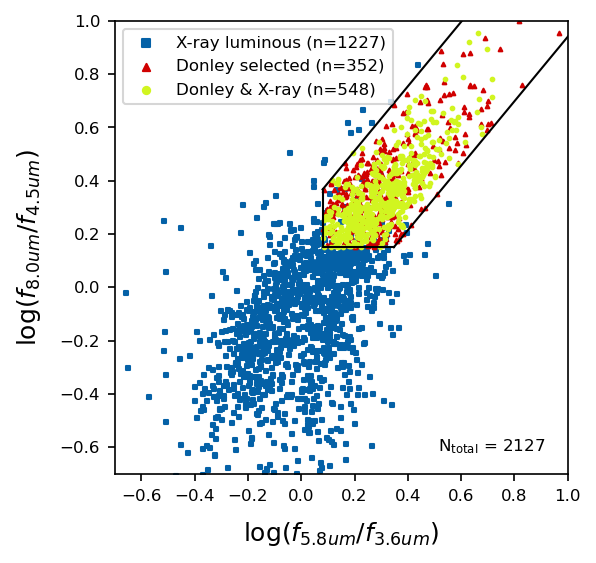

69.12676056338029 % of Xray-selected sources fall outside wedge or are not monotomically rising.
39.111111111111114 % of MIR-selected sources have no Xray greater than 10^43


In [13]:
PlotDonleyTricolor(
    xy_IRAC_tri['BLU']['x'], xy_IRAC_tri['BLU']['y'], 
    xy_IRAC_tri['RED']['x'], xy_IRAC_tri['RED']['y'], 
    xy_IRAC_tri['YEL']['x'], xy_IRAC_tri['YEL']['y'], 
    path=adp.path_fig, fileName='v2_colorcolorDiagram_tri',   # save
    saveNum=2,              # 3=full,zoom,zoom w/legend. 2= zoom,zoom w/legend. 1=zoom w/legend. 0=none
    printInfo=True          # output text
)

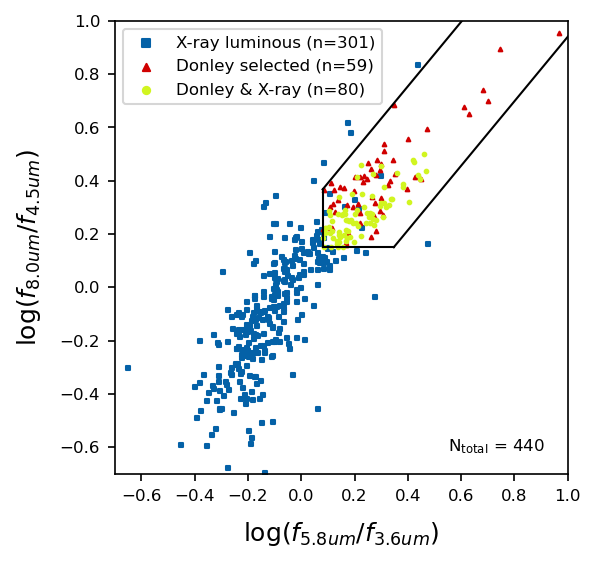

79.00262467191601 % of Xray-selected sources fall outside wedge or are not monotomically rising.
42.44604316546763 % of MIR-selected sources have no Xray greater than 10^43


In [14]:
PlotDonleyTricolor(
    xy_IRAC_tri_le['BLU']['x'], xy_IRAC_tri_le['BLU']['y'], 
    xy_IRAC_tri_le['RED']['x'], xy_IRAC_tri_le['RED']['y'], 
    xy_IRAC_tri_le['YEL']['x'], xy_IRAC_tri_le['YEL']['y'], 
    path=adp.path_fig, fileName='v2_colorcolorDiagram_tri_z01',   # save
    saveNum=2,              # 3=full,zoom,zoom w/legend. 2= zoom,zoom w/legend. 1=zoom w/legend. 0=none
    printInfo=True          # output text
)